In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import joblib
from random import randint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

In [2]:
Housing_price=pd.read_csv('Beijing_housing_price.csv') #, sep=',', encoding='iso-8859-1', low_memory=False)
cols = [i for i in Housing_price.columns if i not in ['tradeTime']]
for col in cols:
    Housing_price[col] = pd.to_numeric(Housing_price[col], errors = 'coerce')
Housing_price['tradeTime'] = pd.to_datetime(Housing_price['tradeTime'], format = '%m/%d/%y')

Housing_price=Housing_price.drop(['constructionTime'], axis=1)

In [13]:
#Housing_price=Housing_price.drop(['DOM', 'followers', 'kitchen','communityAverage'], axis=1)

In [3]:
Housing_price.head()

,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,...,bathRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,2016-08-09,1464,106,415.0,31680,131.00,2,1,...,1,1,3,6,0.217,1,0,1,7,56021
1,116.453917,39.881534,2016-07-28,903,126,575.0,43436,132.38,2,2,...,2,1,4,6,0.667,1,1,0,7,71539
2,116.561978,39.877145,2016-12-11,1271,48,1030.0,52021,198.00,3,2,...,3,4,3,6,0.500,1,0,0,7,48160
3,116.438010,40.076114,2016-09-30,965,138,297.5,22202,134.00,3,1,...,1,1,1,6,0.273,1,0,0,6,51238
4,116.428392,39.886229,2016-08-28,927,286,392.0,48396,81.00,2,1,...,1,4,2,2,0.333,0,1,1,1,62588


In [75]:
Housing_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152266 entries, 0 to 152265
Data columns (total 21 columns):
Lng                    152266 non-null float64
Lat                    152266 non-null float64
tradeTime              152266 non-null datetime64[ns]
DOM                    152266 non-null int64
followers              152266 non-null int64
totalPrice             152266 non-null float64
price                  152266 non-null int64
square                 152266 non-null float64
livingRoom             152266 non-null int64
drawingRoom            152266 non-null int64
kitchen                152266 non-null int64
bathRoom               152266 non-null int64
buildingType           152266 non-null int64
renovationCondition    152266 non-null int64
buildingStructure      152266 non-null int64
ladderRatio            152266 non-null float64
elevator               152266 non-null int64
fiveYearsProperty      152266 non-null int64
subway                 152266 non-null int64
district       

# Data Exploration

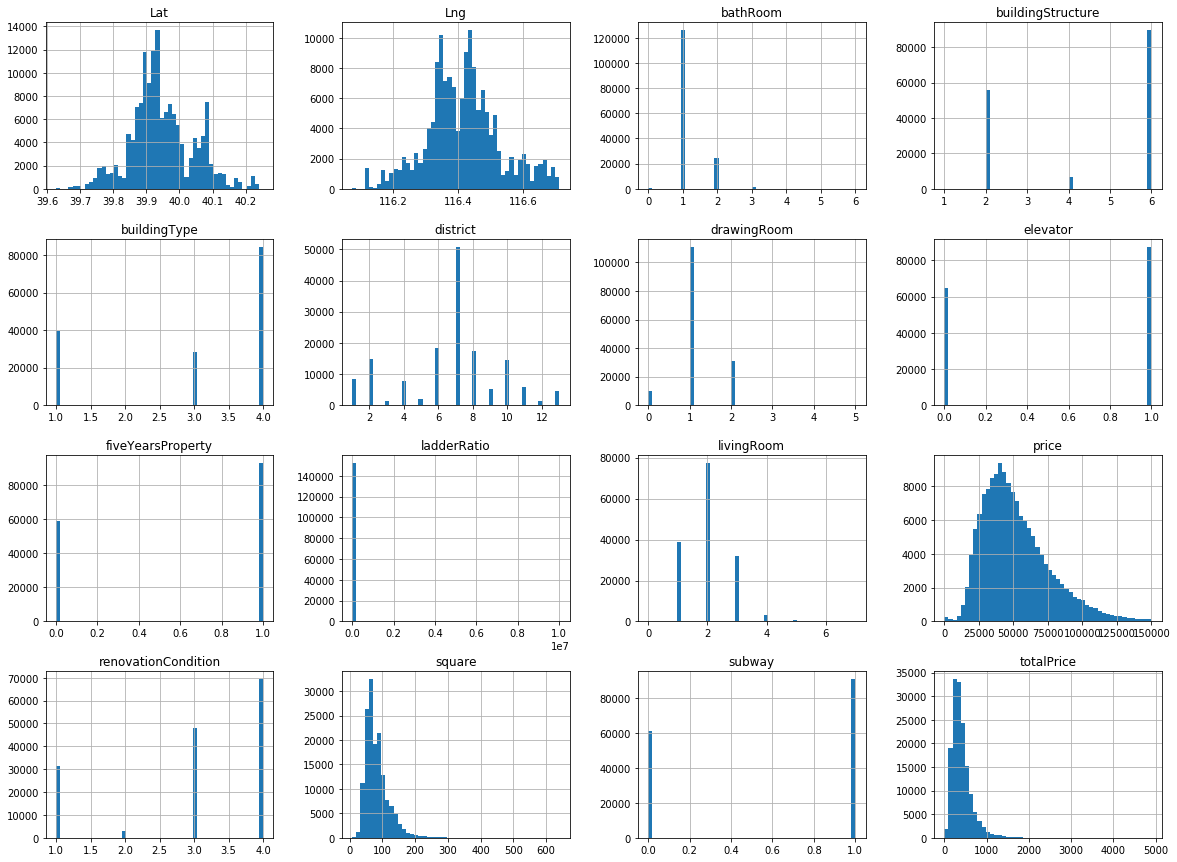

In [16]:
Housing_price.hist(bins=50, figsize=(20,15))
plt.show()

No handles with labels found to put in legend.


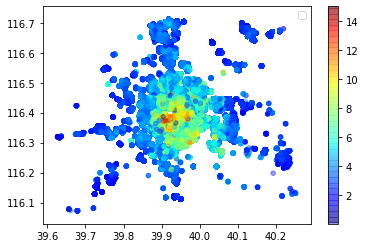

In [17]:
fig = plt.scatter(x=Housing_price['Lat'], y=Housing_price['Lng'], alpha=0.4, \
    #s=Housing_price['price']/10000, label='Price', \
                  s=20,\
    c=Housing_price['price']/10000, cmap=plt.get_cmap('jet'))
plt.colorbar(fig)
plt.legend()
plt.show()

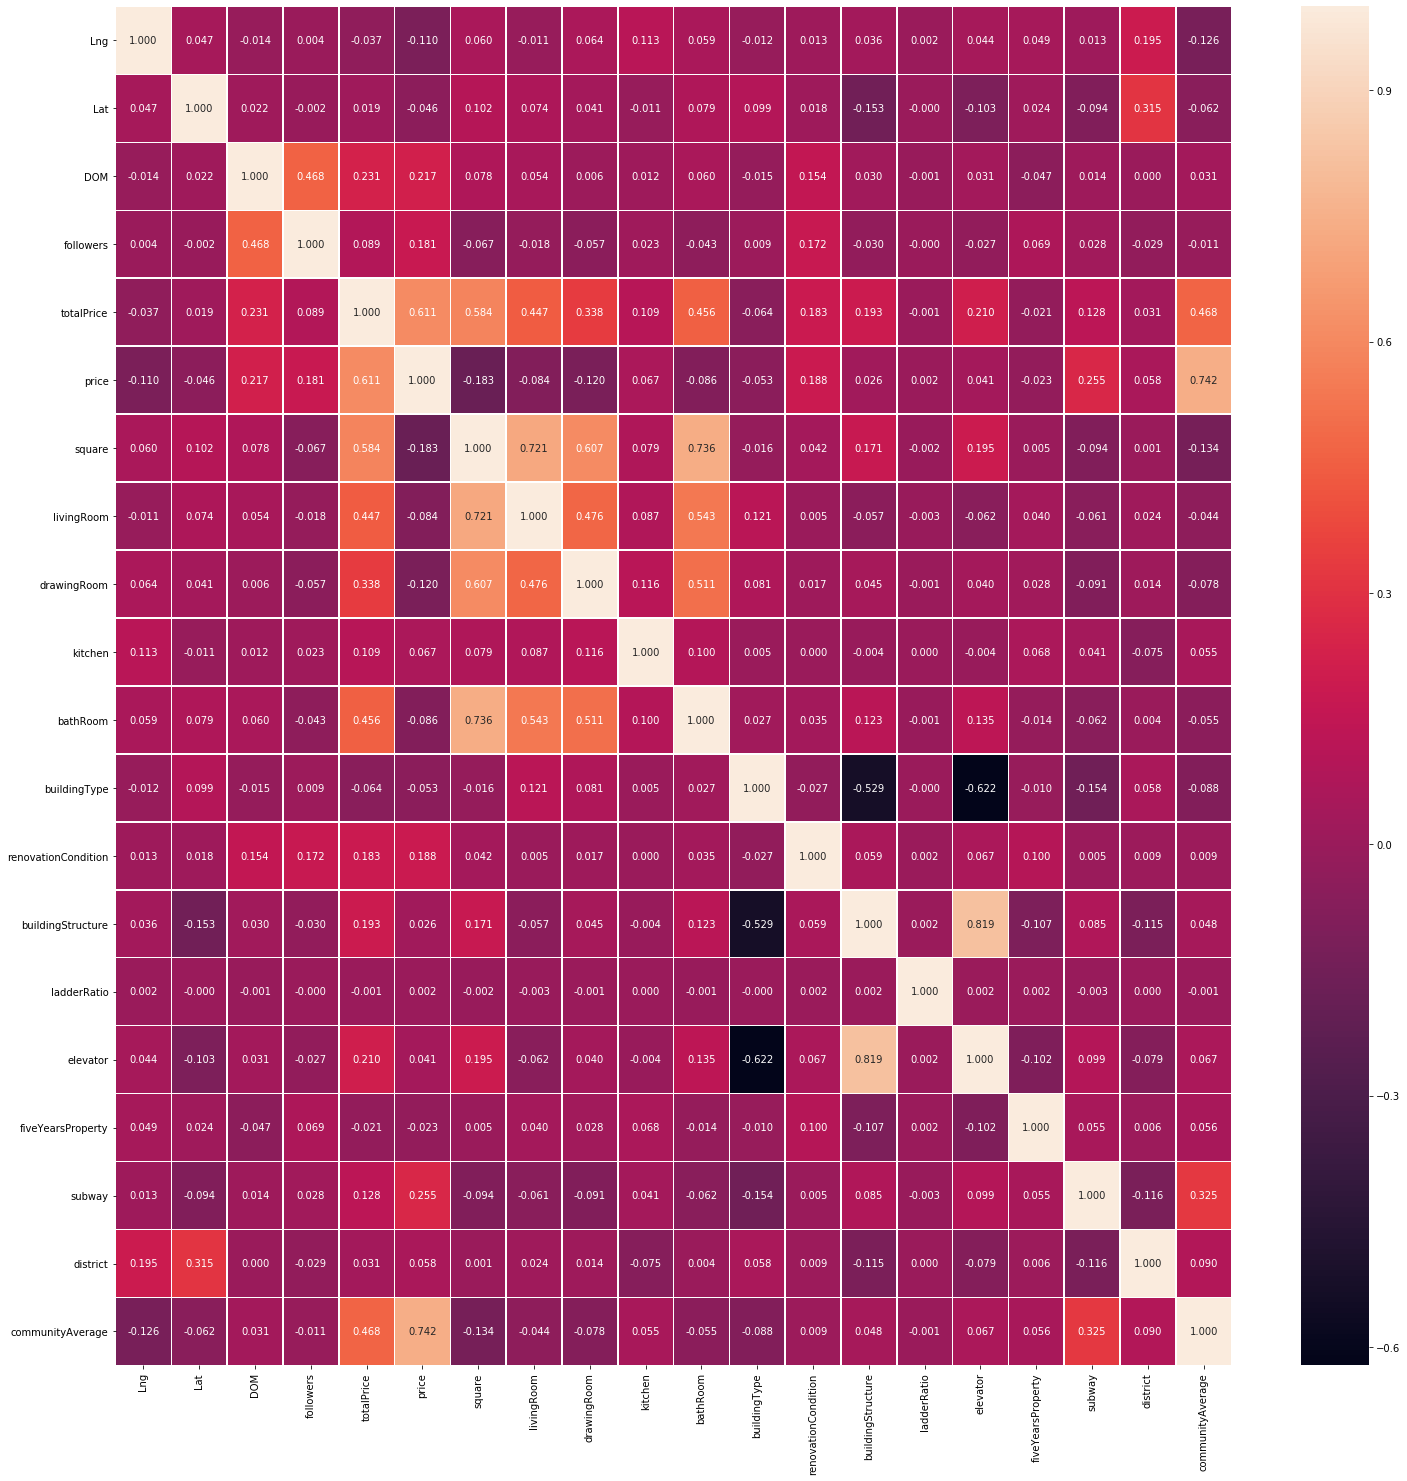

In [4]:
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(Housing_price.corr(), annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.show()

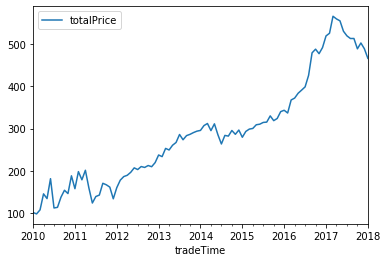

In [5]:
price_by_trade_time = pd.DataFrame()
price_by_trade_time['totalPrice'] = Housing_price['totalPrice']
price_by_trade_time.index = Housing_price['tradeTime'].astype('datetime64[ns]')
price_by_trade_month = price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
price_by_trade_month.plot(kind='line')
plt.show()

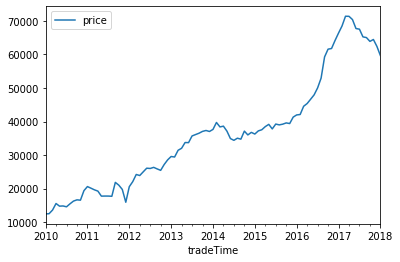

In [6]:
avg_price_by_trade_time= pd.DataFrame()
avg_price_by_trade_time['price'] = Housing_price['price']
avg_price_by_trade_time.index = Housing_price['tradeTime'].astype('datetime64[ns]')
avg_price_by_trade_month = avg_price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
avg_price_by_trade_month.plot(kind='line')
plt.show()

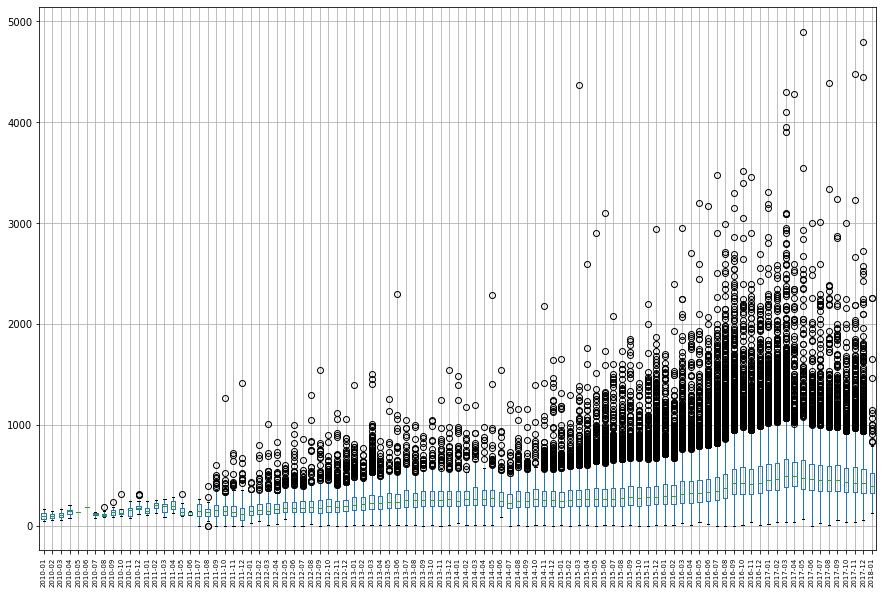

In [21]:
price_stat_trade_month_index = [x.strftime('%Y-%m') for x in set(price_by_trade_time.to_period('M').index)]
price_stat_trade_month_index.sort()
price_stat_trade_month = []
for month in price_stat_trade_month_index:
    price_stat_trade_month.append(price_by_trade_time[month]['totalPrice'].values)
price_stat_trade_month = pd.DataFrame(price_stat_trade_month)
price_stat_trade_month.index = price_stat_trade_month_index
price_stat_trade_month = price_stat_trade_month.T
price_stat_trade_month.boxplot(figsize=(15,10))
plt.xticks(rotation=90,fontsize=7)
plt.show()

# Making traing and testing data set

In [44]:
from sklearn.preprocessing import scale

In [45]:
X=Housing_price.drop(['totalPrice','price', 'kitchen','tradeTime'], axis=1)

#X['communityAverage']=X['communityAverage']/10000
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scale(np.array(X)), scale(np.array(Housing_price['price'])), test_size=0.3, random_state=27)


In [46]:
X.head()

,Lng,Lat,DOM,followers,square,livingRoom,drawingRoom,bathRoom,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,116.475489,40.019520,1464,106,131.00,2,1,1,1,3,6,0.217,1,0,1,7,56021
1,116.453917,39.881534,903,126,132.38,2,2,2,1,4,6,0.667,1,1,0,7,71539
2,116.561978,39.877145,1271,48,198.00,3,2,3,4,3,6,0.500,1,0,0,7,48160
3,116.438010,40.076114,965,138,134.00,3,1,1,1,1,6,0.273,1,0,0,6,51238
4,116.428392,39.886229,927,286,81.00,2,1,1,4,2,2,0.333,0,1,1,1,62588


In [47]:
print(y_train[0:100])

[ 2.80764262e-01 -1.02090698e-01  9.39741619e-01 -1.75590905e-01
 -2.08947417e-01  4.58886383e-01  4.06884187e-02 -4.44222571e-01
  3.83606611e-01  8.50473631e-01  8.25021702e-01  4.44070463e-01
  4.20127467e-02 -7.89977282e-02  9.16814189e-01  2.54172609e-02
  1.49529723e+00  2.16296549e+00  4.31406576e-01  6.54100614e-01
  1.40325643e+00 -5.55755823e-01  1.15908345e+00  1.04918329e-01
 -1.00805524e+00 -6.14109028e-01 -8.09074947e-01  2.32283672e+00
 -5.59894349e-01  2.19141622e-01  1.84897559e+00 -8.14372259e-01
 -6.77842315e-01 -1.10696599e+00 -3.56154756e-01 -1.22259638e+00
 -5.65522743e-01 -7.33133011e-01 -8.16151825e-01 -4.00561131e-01
  8.30608711e-01  1.11807345e-02 -8.62373661e-04  3.26536350e-01
 -3.68570332e-01 -2.47684013e-01  9.73448277e-02  8.62061502e-01
 -5.80297278e-01  5.57010814e-01 -1.56884771e-01 -1.16250499e+00
  1.80701095e+00 -9.99778185e-01  2.39379010e-01  9.15696788e-01
 -7.42237766e-01  2.08561646e+00 -1.68927879e-01 -5.17433081e-01
 -1.24800692e+00 -1.20589

# Model 1: Linear Regression

In [48]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
print(reg.intercept_)
reg_pred_train = reg.predict(X_train)
reg_pred_test = reg.predict(X_test)

from sklearn.metrics import mean_squared_error
print("train error: " + str(mean_squared_error(y_train, reg_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, reg_pred_test)))

[-0.00645614  0.00864585  0.12913798  0.10045943 -0.13167566  0.02363206
 -0.00520953  0.02899903  0.01364418  0.15538813 -0.01048236  0.00229126
  0.01322332 -0.07871159  0.0111925  -0.0078193   0.7250996 ]
0.00019326862686334213
train error: 0.3614382348065837
test error:  0.3655102625765632


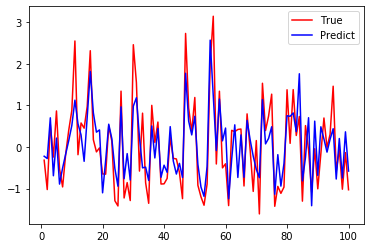

In [49]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, reg_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.show()

# Model 2: LinearSVR

In [50]:
lin_svm_reg = LinearSVR(C=0.5,loss='squared_epsilon_insensitive')
lin_svm_reg.fit(X_train,y_train)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='squared_epsilon_insensitive',
          max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [51]:
SVM_pred_train=lin_svm_reg.predict(X_train)
SVM_pred_test=lin_svm_reg.predict(X_test)

In [52]:
print("train error: " + str(mean_squared_error(y_train, SVM_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, SVM_pred_test)))

train error: 0.3614386626232887
test error:  0.36552127833825987


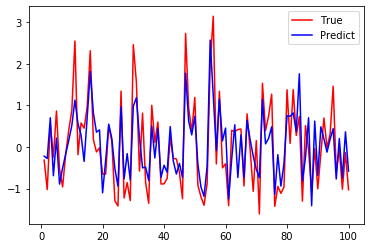

In [53]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, SVM_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.show()

# Model 5: Neural Network

In [59]:
from sklearn.neural_network import MLPRegressor
NN = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.2)
NN.fit(X_train, y_train)

NN_pred_train = NN.predict(X_train)
NN_pred_test = NN.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN_pred_test)))

train error: 0.3821516119498913
test error:  0.4194836572527112


In [61]:
NN1 = MLPRegressor(learning_rate='adaptive', learning_rate_init=0.1)
NN1.fit(X_train, y_train)

NN1_pred_train = NN1.predict(X_train)
NN1_pred_test = NN1.predict(X_test)
print("train error: " + str(mean_squared_error(y_train, NN1_pred_train)))
print("test error:  " + str(mean_squared_error(y_test, NN1_pred_test)))

train error: 0.2346669099931503
test error:  0.23497728418903865


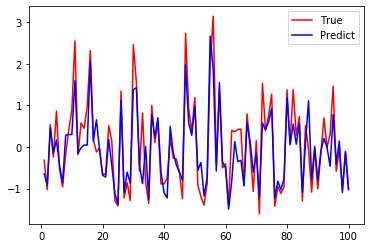

In [62]:
x = [i+1 for i in range(100)]
plt.plot(x, y_test[0:100], c='red', label='True')
plt.plot(x, NN1_pred_test[0:100], c='blue', label='Predict')
plt.legend()
plt.show()

In [57]:
print(NN1_pred_test[0:100])

[-1.17890648 -0.07407814 -0.07407814 -0.38421426 -0.07407814 -0.07407814
 -1.24370891 -0.07407814 -0.07407814 -0.07407814  0.86070529 -0.07407814
 -0.07407814 -0.07407814 -0.07407814 -0.07407814  0.19022569 -0.07407814
 -0.07407814 -0.07407814 -0.07407814  1.88747536 -0.41996342 -0.07407814
 -0.07407814  1.70187945 -0.07407814 -0.07407814 -0.07407814  1.4723479
  1.26452352 -0.07407814 -0.07407814 -0.07407814 -0.07407814  0.97499286
 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814
 -0.07407814 -0.07407814  1.55357242 -0.07407814 -0.07407814 -0.07407814
 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814
  3.58958138 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814
 -0.07407814 -0.07407814  0.76656637 -0.07407814 -0.07407814 -0.07407814
  0.44105705 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814
 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.07407814
 -0.07407814 -0.07407814 -0.07407814 -0.07407814 -0.

# Model 5: Time Series Prediction

In [38]:
avg_price_by_trade_time = avg_price_by_trade_time.sort_values(['tradeTime'],ascending=True)

In [39]:
avg_price_by_trade_time.head()

,price
tradeTime,
2016-06-15,90283
2016-06-15,123956
2016-06-15,65385
2016-06-15,46612
2016-06-15,41953


In [40]:
avg_price_by_trade_time = price_by_trade_time.resample('M').mean()
avg_price_by_trade_time.head()

,totalPrice
tradeTime,
2016-06-30,405.996323
2016-07-31,419.035955
2016-08-31,477.855062
2016-09-30,555.417460
2016-10-31,666.074026


In [41]:
price_by_trade_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2016-08-09 to 2016-06-30
Data columns (total 1 columns):
totalPrice    10000 non-null float64
dtypes: float64(1)
memory usage: 156.2 KB


In [42]:
import seaborn as sns
sns.set(style = "darkgrid")
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import cm
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [43]:
forecast = avg_price_by_trade_time
forecast = forecast.rename(columns={ 'totalPrice': "y" })
forecast.reset_index(level=0, inplace=True)
forecast = forecast.rename(columns={ 'tradeTime': "ds" })

In [44]:
from scipy.stats import boxcox
forecast['y'], lam = boxcox(forecast['y'])

model = Prophet()
model.fit(forecast)

/Users/xurui1993/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1038: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.


In [45]:
future = model.make_future_dataframe(periods=6, freq = 'm')
future.tail()

,ds
18,2017-12-31
19,2018-01-31
20,2018-02-28
21,2018-03-31
22,2018-04-30


In [46]:
#predicting the future model
forecast = model.predict(future)
forecast_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

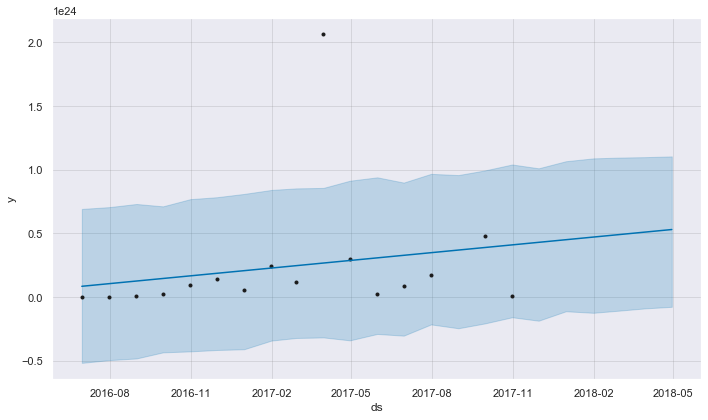

In [47]:
model.plot(forecast_data);